## Data Exploration

In [1]:
import pandas as pd

df = pd.read_csv('SC_NC_combined_v1.csv')

In [2]:
# Drop the 'state column' since that won't be used for the classification
df.drop(columns='state', inplace=True)

In [3]:
df

,year,act,jim_crow
0,1879,AN ACT to PREVENT AND PunisH THE INTERMARRYING...,1
1,1879,Section 1.,0
2,1879,Be it enacted by the Senate and House of Repre...,1
3,1879,Sec. 2.,0
4,1879,Any person who shall violate the first Section...,1
...,...,...,...
6469,1955,In all cases in which a municipality has a col...,1
6470,1955,That appropriations made to the Oxford Colored...,1
6471,1959,That appropriations made to the Oxford Colored...,1
6472,1961,"G. S. -, as the same presently appears in the ...",1


<Axes: xlabel='jim_crow', ylabel='count'>

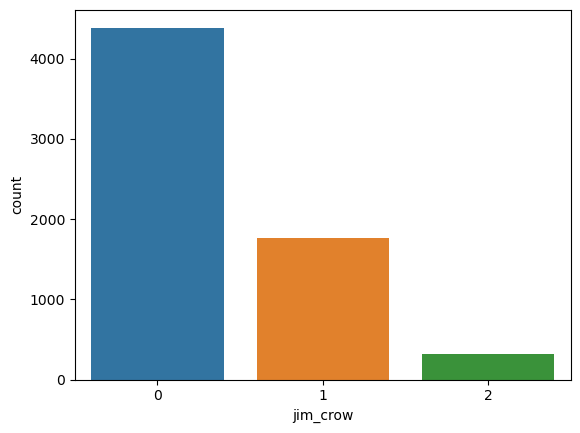

In [4]:
from seaborn import countplot

# Plot the distribution of the target
countplot(x=df['jim_crow'])

In [5]:
# Check for missing values
df.isnull().sum().sum()

0

In [6]:
# Split data
features = df[['year', 'act']]
target = df['jim_crow']

In [7]:
print(features.shape, target.shape)

(6474, 2) (6474,)


In [8]:
features

,year,act
0,1879,AN ACT to PREVENT AND PunisH THE INTERMARRYING...
1,1879,Section 1.
2,1879,Be it enacted by the Senate and House of Repre...
3,1879,Sec. 2.
4,1879,Any person who shall violate the first Section...
...,...,...
6469,1955,In all cases in which a municipality has a col...
6470,1955,That appropriations made to the Oxford Colored...
6471,1959,That appropriations made to the Oxford Colored...
6472,1961,"G. S. -, as the same presently appears in the ..."


<br>

## Feature Extraction

Since the dataset in a string format, it needs to be converted to something numeric.
- Apply TFIDFVectorizer for the acts
- Apply Dummy Encoding for the years (using OneHotEncoder)

Combine the outputs of TFIDFVectorizer and Dummy Encoding using ColumnTransformer, which returns a sparse matrix

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# columnTransformer = ColumnTransformer(
#     [('ohe', OneHotEncoder(dtype='int', drop='first', handle_unknown='ignore'), ['year']),
#      ('tfidf', TfidfVectorizer(decode_error='ignore', stop_words=None, max_features=100000), 'act')],
#     remainder='drop')

columnTransformer = ColumnTransformer(
    [('ohe', OneHotEncoder(dtype='int', drop='first', handle_unknown='ignore'), [0]),
     ('tfidf', TfidfVectorizer(decode_error='ignore', stop_words=None, max_features=100000), 1)],
    remainder='drop')

vector_transformer = columnTransformer.fit(features)
vectorized_df = vector_transformer.transform(features)

In [10]:
vectorized_df

<6474x11116 sparse matrix of type '<class 'numpy.float64'>'
	with 235305 stored elements in Compressed Sparse Row format>

<br>

## Using SMOTE to Fix Imbalanced Classes

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(vectorized_df.toarray(), target)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10528, 11116) (10528,)
(2633, 11116) (2633,)


<br>

# Testing different ways to run models

## 1. Independent Models
Run each model by independently.

### XGBoost

In [14]:
from xgboost import XGBClassifier

xgbC = XGBClassifier(objective='multi:softprob', random_state=13)
xgbC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [15]:
xgbC_pred = xgbC.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(xgbC_pred, y_test))
print(classification_report(y_test, xgbC_pred))

Accuracy 0.9574629699962021
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       868
           1       0.97      0.95      0.96       890
           2       0.97      0.96      0.97       875

    accuracy                           0.96      2633
   macro avg       0.96      0.96      0.96      2633
weighted avg       0.96      0.96      0.96      2633



<br>

### HistGradientBoostingClassifier

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbC = HistGradientBoostingClassifier(random_state=13)
hgbC.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=13)

In [18]:
hgbC_pred = hgbC.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(hgbC_pred, y_test))
print(classification_report(y_test, hgbC_pred))

Accuracy 0.9642992783896696
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       868
           1       0.97      0.96      0.97       890
           2       0.97      0.98      0.98       875

    accuracy                           0.96      2633
   macro avg       0.96      0.96      0.96      2633
weighted avg       0.96      0.96      0.96      2633



<br>

### SGD

In [20]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier()

In [21]:
sgd_pred = sgd.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(sgd_pred, y_test))
print(classification_report(y_test, sgd_pred))

Accuracy 0.9468287124952526
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       868
           1       0.94      0.95      0.95       890
           2       0.93      0.99      0.96       875

    accuracy                           0.95      2633
   macro avg       0.95      0.95      0.95      2633
weighted avg       0.95      0.95      0.95      2633



<br>

## 2. KFold and Cross validation
Run each model through a stratified kfold with cross validation.

In [31]:
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_models(X_train, y_train, X_test, y_test, models, scoring) -> pd.DataFrame:
    '''
    Test models with a Stratified KFold and cross_validation.
    Prints the classification report for each model and
    
    :param X_train : Training vector
    :param y_train : Training target vector
    :param X_test  : Test vector
    :param y_test  : Test target vector
    :models        : A list of two valued tuples containing the string name followed by the model
    :scoring       : A list of scoring metrics
    
    :return        : A DataFrame of predictions (not sorted)
    '''
    
    dfs = []  # List of dataframes 
    
    results = []  # Cross validations resuls
    names = []  # Model names
    
    for name, model in models:
        kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
        
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs = -1, verbose=2)

        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(f"\n\n--{name}--")
        print(classification_report(y_test, y_pred))

        data = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        # use sns.heatmap on top of confusion_matrix to show the confusion matrix
        ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')
        ax.set(title="Overall")
        plt.show()
        
        results.append(cv_results)
        names.append(name)
        
        temp_df = pd.DataFrame(cv_results)
        temp_df['model'] = name        
        dfs.append(temp_df)
        
    return pd.concat(dfs, ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.5min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.5min finished




--HGB--
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       868
           1       0.97      0.96      0.96       890
           2       0.97      0.97      0.97       875

    accuracy                           0.96      2633
   macro avg       0.96      0.96      0.96      2633
weighted avg       0.96      0.96      0.96      2633



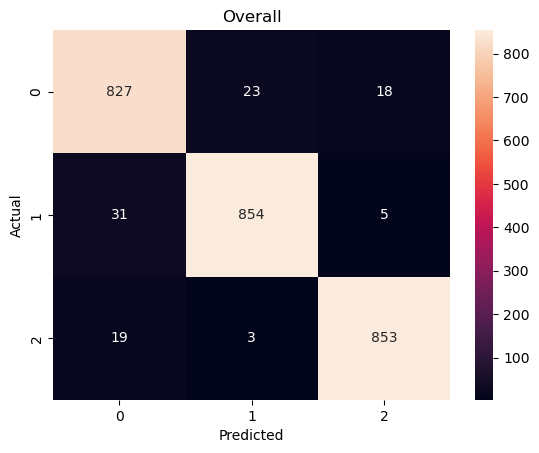

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished




--CNB--
              precision    recall  f1-score   support

           0       0.93      0.67      0.78       868
           1       0.79      0.89      0.84       890
           2       0.80      0.92      0.85       875

    accuracy                           0.83      2633
   macro avg       0.84      0.83      0.83      2633
weighted avg       0.84      0.83      0.83      2633



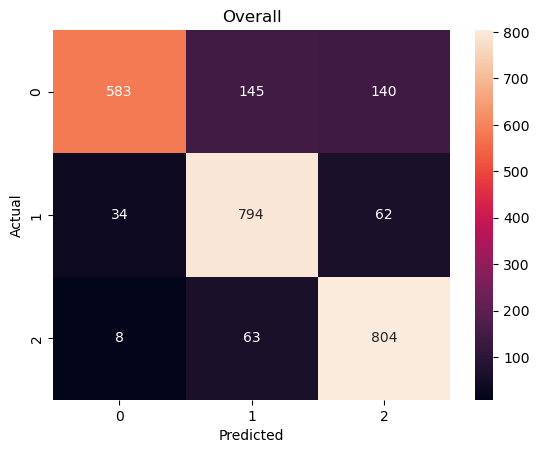

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 8.5min
[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time= 8.5min
[CV] END .................................................... total time=   2.7s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 20.2min remaining: 30.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.3min finished




--XGB--
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       868
           1       0.97      0.95      0.96       890
           2       0.97      0.96      0.97       875

    accuracy                           0.96      2633
   macro avg       0.96      0.96      0.96      2633
weighted avg       0.96      0.96      0.96      2633



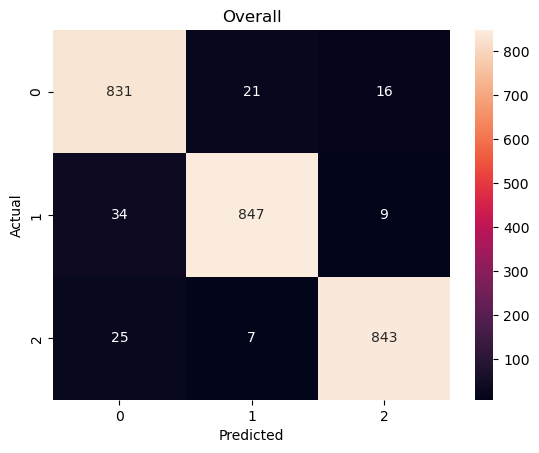

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.2s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished




--SGD--
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       868
           1       0.94      0.95      0.95       890
           2       0.92      0.99      0.96       875

    accuracy                           0.94      2633
   macro avg       0.95      0.94      0.94      2633
weighted avg       0.95      0.94      0.94      2633



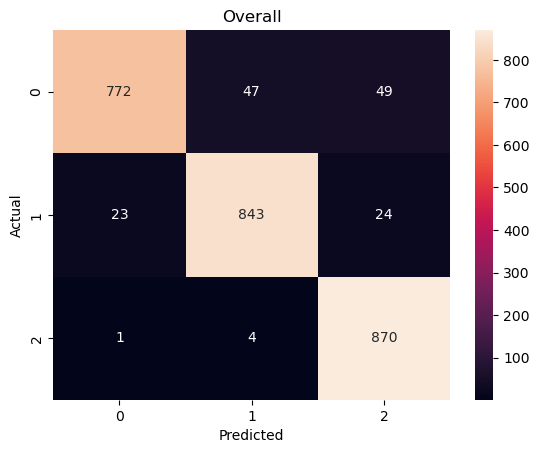

In [32]:
from sklearn.naive_bayes import ComplementNB

models = [
    ('HGB', HistGradientBoostingClassifier()),
    ('CNB', ComplementNB()),
    ('XGB', XGBClassifier()),
    ('SGD', SGDClassifier())
]

scoring = ['f1_weighted', 'f1_macro', 'f1_micro']

result_df = run_models(X_train, y_train, X_test, y_test, models, scoring)

In [50]:
result_df.sort_values('fit_time')

,fit_time,score_time,test_f1_weighted,test_f1_macro,test_f1_micro,model
7,2.474931,0.203654,0.823641,0.823672,0.826211,CNB
8,2.482068,0.212139,0.825344,0.825390,0.828029,CNB
9,2.482519,0.210998,0.808202,0.808276,0.812352,CNB
6,2.491436,0.216279,0.819080,0.819117,0.822887,CNB
5,2.497643,0.210117,0.802944,0.802986,0.805318,CNB
19,13.153802,0.126946,0.947458,0.947472,0.947743,SGD
15,13.592012,0.064525,0.939818,0.939832,0.940171,SGD
17,14.713692,0.064832,0.947910,0.947915,0.948243,SGD
18,15.365719,0.052869,0.935061,0.935082,0.935392,SGD
16,15.528117,0.050355,0.935952,0.935952,0.936372,SGD


In [53]:
result_df.sort_values('test_f1_weighted', ascending=False)

,fit_time,score_time,test_f1_weighted,test_f1_macro,test_f1_micro,model
4,508.007566,0.817845,0.960574,0.960576,0.960570,HGB
1,506.162179,1.029533,0.960159,0.960151,0.960114,HGB
0,506.139750,1.033733,0.957812,0.957826,0.957740,HGB
3,507.891276,0.839539,0.957730,0.957739,0.957720,HGB
2,504.228133,1.276114,0.957711,0.957709,0.957740,HGB
13,1218.290199,0.213095,0.952557,0.952570,0.952494,XGB
12,1211.095446,0.267720,0.951108,0.951112,0.951092,XGB
10,1214.185436,0.228630,0.950227,0.950241,0.950142,XGB
14,1209.968687,0.308280,0.949612,0.949616,0.949644,XGB
11,1217.563670,0.215977,0.949242,0.949234,0.949193,XGB


<br>

## 3. Pipelines
The problem with the above steps might be data leakage since the test split above was performed after ColumnTransformation on the entire feature space. Then, SMOTE was applied to the features and target. Lastly, the test-train-split was done.
<br>However, this might caused [Data leakage during pre-processing](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage-during-pre-processing).

To avoid such errors, a pipeline (from `imblearn`, since that incorporated SMOTE) is used below.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [55]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pipe = Pipeline(steps=[('ct', columnTransformer),
                       ('SMOTE', SMOTE(random_state = 13, k_neighbors = 5)),
                       ('classifier', XGBClassifier(objective='multi:softprob', random_state=13))])                        

In [56]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                dtype='int',
                                                                handle_unknown='ignore'),
                                                  [0]),
                                                 ('tfidf',
                                                  TfidfVectorizer(decode_error='ignore',
                                                                  max_features=100000),
                                                  1)])),
                ('SMOTE', SMOTE(random_state=13)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=N...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

- Simple predict

In [57]:
# The fit also goes through the pipe
pi_pre = pipe.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy %s' % accuracy_score(pi_pre, y_test))
print(classification_report(y_test, pi_pre))

Accuracy 0.8918918918918919
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       868
           1       0.95      0.82      0.88       369
           2       0.32      0.24      0.27        58

    accuracy                           0.89      1295
   macro avg       0.72      0.68      0.70      1295
weighted avg       0.89      0.89      0.89      1295



- With grid search

In [59]:
param_grid = [
    {
        'classifier' : [XGBClassifier(objective='multi:softprob', random_state=13)],
        'classifier__learning_rate': [0.2, 0.4],
        'classifier__max_depth': [9, 12],
        'classifier__min_child_weight': [1, 3],
        'classifier__gamma': [1, 2],
        'classifier__colsample_bytree' : [0.5, 0.6],
    }
]

In [60]:
grid_search = GridSearchCV(pipe,
                           param_grid = param_grid,
                           n_jobs = -1,
                           cv = 5,
                           scoring='f1_weighted',
                           verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/nitingupta/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nitingupta/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nitingupta/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nitingupta/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nitingupta/miniconda3/lib/python3

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='int',
                                                                                       handle_unknown='ignore'),
                                                                         [0]),
                                                                        ('tfidf',
                                                                         TfidfVectorizer(decode_error='ignore',
                                                                                         max_features=100000),
                                                                         1)])),
                                       ('SMOTE', SMOTE(random_state=13)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_byl...
                                                       min_child_weight=3,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       objective='multi:softprob',
                                                       predictor=None, ...)],
                          'classifier__colsample_bytree': [0.5, 0.6],
                          'classifier__gamma': [1, 2],
                          'classifier__learning_rate': [0.2, 0.4],
                          'classifier__max_depth': [9, 12],
                          'classifier__min_child_weight': [1, 3]}],
             scoring='f1_weighted', verbose=2)

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

xgbC_pred = grid_search.predict(X_test)
print('Accuracy %s' % accuracy_score(xgbC_pred, y_test))
print(classification_report(y_test, xgbC_pred))

Accuracy 0.9011583011583012
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       868
           1       0.95      0.84      0.89       369
           2       0.37      0.19      0.25        58

    accuracy                           0.90      1295
   macro avg       0.74      0.67      0.69      1295
weighted avg       0.89      0.90      0.89      1295



In [70]:
grid_search.best_score_

0.8805537724462894

In [69]:
grid_search.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.2, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=12, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 'classifier__colsample_bytree': 0.5,
 'classifier__gamma': 1,
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 12,
 'classifier__min_child_weight': 3}